### Project for "Wikishop" using BERT

### Project Description:
<div style="border:solid Chocolate 2px; padding: 40px">
    
#### Objective:
    
- The goal of the project is to develop a machine learning model capable of classifying user comments as positive or negative, with the aim of identifying toxic comments that will be sent for moderation.

#### Project Tasks:

#### Data Collection and Analysis:

- Study the provided dataset with comments and their toxicity labels.
- Perform preliminary data processing, including text cleaning, stop word removal, and converting text to lowercase.
    
#### Model Development:

- Apply various text processing methods such as TF-IDF or word vectorization using bag-of-words models.
- Train different classification models (logistic regression, random forest, gradient boosting, etc.) on the prepared data.
- Optimize hyperparameters to improve model performance.
    
#### Model Evaluation:

- Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.
    
#### Conclusion:
    
-The developed model will become an important part of the "Wikishop" e-commerce ecosystem, helping to improve user experience and maintain a high standard of communication on the platform.

<div style="border:solid Chocolate 2px; padding: 40px">

### Project Plan
    
1. Data Preparation

- Clean and preprocess the dataset to ensure consistency and quality for model training.
2. Text Lemmatization

- Perform text lemmatization to reduce words to their base forms, improving the quality of input data for the models.
    
3. Training the Logistic Regression Model

- Train a logistic regression model using the preprocessed text data for classification.

4. Training a Pretrained BERT Model

- Implement and fine-tune a pretrained BERT (Bidirectional Encoder Representations from Transformers) model for text classification.

## 1. Data Loading

In [1]:
import re
import nltk
import optuna
import shap

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer 
from tqdm import notebook
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from optuna.integration import OptunaSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import Trainer, TrainingArguments, AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
try:
    df = pd.read_csv('toxic_comments.csv')
except FileNotFoundError:
    df = pd.read_csv('C:\\Users\\User\\Downloads\\toxic_comments.csv')

In [5]:
display(df.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<div style="border:solid Chocolate 2px; padding: 40px">
    
#### Intermediate Conclusion:

The data contains the following columns:

- Unnamed: 0: Row index (this can be removed as it does not provide useful information).
- text: The text of the comment.
- toxic: Label indicating the toxicity of the comment (0 — non-toxic, 1 — toxic).

### 1.2 Data Preparation

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'(?:\n|\r)', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

df.head()

,text,toxic,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


<div style="border:solid Chocolate 2px; padding: 40px">
    
### Intermediate Conclusion:

- The Unnamed column was removed as it did not provide any value.
- The text data was cleaned and converted to lowercase.

<div style="border:solid Chocolate 2px; padding: 40px">
    
### 2. Lemmatization

In [8]:
tqdm.pandas()
def spacy_lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['lemmatized_text'] = df['clean_text'].progress_apply(spacy_lemmatize)
display(df.head())

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,clean_text,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...,daww he match this background colour I m seemi...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...,hey man I m really not try to edit war its jus...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestions on impr...,more I can not make any real suggestion on i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


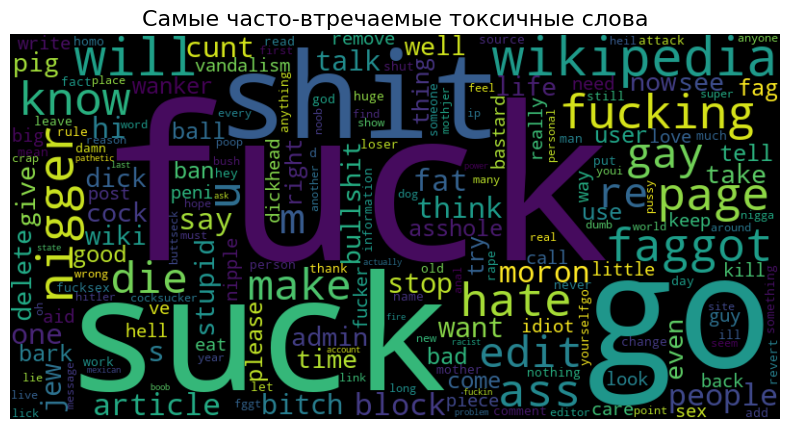

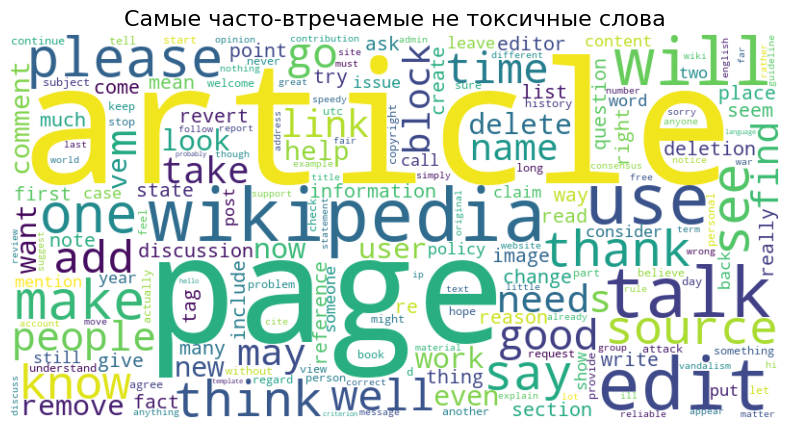

In [9]:
toxic_text = " ".join(df[df['toxic'] == 1]['lemmatized_text'].tolist())
non_toxic_text = " ".join(df[df['toxic'] == 0]['lemmatized_text'].tolist())

wordcloud_toxic = WordCloud(width=800, height=400, background_color='black', collocations=False).generate(toxic_text)
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(non_toxic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.title('Самые часто-втречаемые токсичные слова', fontsize=16)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.title('Самые часто-втречаемые не токсичные слова', fontsize=16)
plt.axis('off')
plt.show()

<div style="border:solid Chocolate 2px; padding: 40px">
    
### Intermediate Conclusion:

- Lemmatization of the text was performed to reduce words to their base forms, which improves the quality of vectorization and, consequently, the model.
- A visualization of toxic and non-toxic words was created. The toxic words are self-explanatory, so no need to elaborate further.

<div style="border:solid Chocolate 2px; padding: 40px">
    
### 3. Training the Logistic Regression Model

In [10]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

In [11]:
X = df['lemmatized_text']
y = df['toxic']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42, stratify=y)

In [13]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english')),
    ('model', LogisticRegression(max_iter=2000, random_state=42))
])

In [14]:
param_distributions = {
    'model__C': optuna.distributions.FloatDistribution(1e-3, 1e3, log=True)
}
optuna_search = OptunaSearchCV(
    pipeline,
    param_distributions,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    n_trials=50,
    random_state=42,
    verbose=1
)
optuna_search.fit(X_train, y_train)

C:\Users\User\AppData\Local\Temp\ipykernel_13824\2312567410.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-09-30 10:32:51,352] A new study created in memory with name: no-name-fd63105f-6671-403f-a3f3-8a755b768137
[I 2024-09-30 10:39:23,492] Trial 3 finished with value: 0.0 and parameters: {'model__C': 0.0015592761347844868}. Best is trial 3 with value: 0.0.
[I 2024-09-30 10:42:20,844] Trial 17 finished with value: 0.0 and parameters: {'model__C': 0.001337291596034202}. Best is trial 3 with value: 0.0.
[I 2024-09-30 10:42:29,152] Trial 18 finished with value: 0.0 and parameters: {'model__C': 0.0010892865301441795}. Best is trial 3 with value: 0.0.
[I 2024-09-30 10:42:42,462] Trial 14 finished with value: 0.017446688758311818 and parameters: {'model__C': 0.005432241149378655}. Best is trial 14 with value: 0.017446688758311818.
[I 2024-09-30 10:42:44,391] Trial 11 finishe

[I 2024-09-30 11:22:03,071] Trial 46 finished with value: 0.7403171838242129 and parameters: {'model__C': 384.4184213809233}. Best is trial 39 with value: 0.7755878570722394.
[I 2024-09-30 11:22:13,161] Trial 48 finished with value: 0.7403458084704557 and parameters: {'model__C': 391.54914985397136}. Best is trial 39 with value: 0.7755878570722394.
[I 2024-09-30 11:22:23,102] Trial 47 finished with value: 0.7373040264703329 and parameters: {'model__C': 506.7510413936703}. Best is trial 39 with value: 0.7755878570722394.
[I 2024-09-30 11:22:30,048] Trial 49 finished with value: 0.7327542001256223 and parameters: {'model__C': 737.2310784935878}. Best is trial 39 with value: 0.7755878570722394.


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('tfidf',
                                          TfidfVectorizer(max_features=10000,
                                                          stop_words='english')),
                                         ('model',
                                          LogisticRegression(max_iter=2000,
                                                             random_state=42))]),
               n_jobs=-1, n_trials=50,
               param_distributions={'model__C': FloatDistribution(high=1000.0, log=True, low=0.001, step=None)},
               random_state=42, scoring='f1', verbose=1)

In [15]:
y_pred = optuna_search.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"Best Parameters: {optuna_search.best_params_}")
print(f"F1-score: {f1:.4f}")

Best Parameters: {'model__C': 10.030399941836789}
F1-score: 0.7751


C:\Users\User\anaconda3\envs\practicum\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


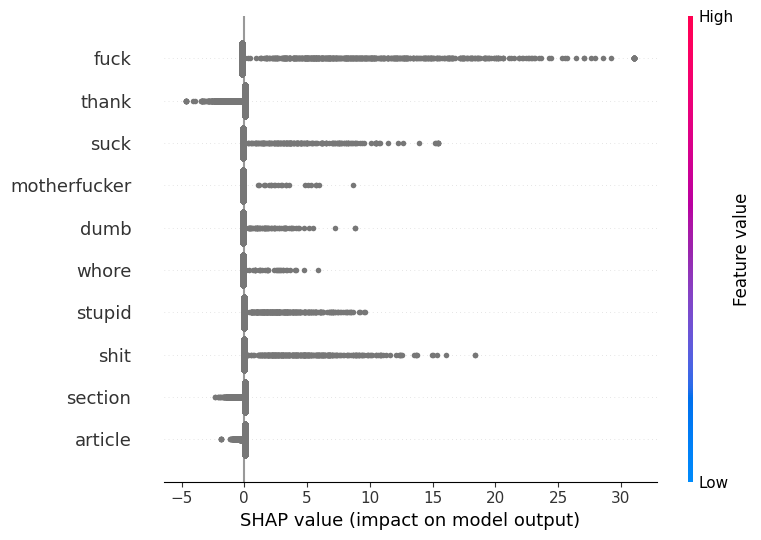

In [16]:
best_pipeline = optuna_search.best_estimator_

vectorizer = best_pipeline.named_steps['tfidf']
model = best_pipeline.named_steps['model']

X_train_tfidf = vectorizer.transform(X_train)

explainer = shap.LinearExplainer(model, X_train_tfidf, feature_perturbation="interventional")

X_test_tfidf = vectorizer.transform(X_test)
shap_values = explainer.shap_values(X_test_tfidf)

shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names(), max_display=10)

<div style="border:solid Chocolate 2px; padding: 40px">

### Intermediate Conclusion:

- Logistic regression with TF-IDF vectorization was used for the initial training, achieving an F1-score of 0.78. This result meets the project's minimum threshold requirement of 0.75. However, we will try to improve it further.
- Additionally, SHAP analysis was performed.
- The SHAP summary plot shows the influence of individual words (features) on the model’s predictions for classifying comments as toxic. Here's how to interpret the plot:
- Most significant words: Words like "fuck," "suck," "motherfucker," and "whore" have a significant positive SHAP value, meaning they strongly contribute to the prediction of a comment being toxic. These words have a large impact on the model’s output, pushing predictions toward the toxic class.

<div style="border:solid Chocolate 2px; padding: 40px">
    
### 3. BERT 

In [17]:
model = AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
df_sample = df.sample(2000, random_state=42)
df_sample['tokenized_text'] = df_sample['lemmatized_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512)
)
max_len = 512
df_sample['padded_text'] = df_sample['tokenized_text'].apply(
    lambda x: x + [0] * (max_len - len(x))
)
df_sample['attention_mask'] = df_sample['padded_text'].apply(
    lambda x: [1 if token != 0 else 0 for token in x]
)
padded = np.array(df_sample['padded_text'].tolist())
attention_mask = np.array(df_sample['attention_mask'].tolist())

batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
    batch_padded = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch_padded, attention_mask=attention_mask_batch)
    
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

  0%|          | 0/21 [00:00<?, ?it/s]

In [19]:
df_sample['bert_embeddings'] = np.concatenate(embeddings, axis=0).tolist()
features = np.array(df_sample['bert_embeddings'].tolist())
y = df_sample['toxic']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)
pipeline = Pipeline([
    ('model', LogisticRegression(max_iter=1000))
])

param_distributions = {
    'model__C': optuna.distributions.FloatDistribution(1e-3, 1e3, log=True)
}

In [21]:
optuna_search = OptunaSearchCV(
    pipeline,
    param_distributions,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    n_trials=50,
    random_state=42,
    verbose=1
)
optuna_search.fit(X_train, y_train)
y_pred = optuna_search.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"Best Parameters: {optuna_search.best_params_}")
print(f"F1-score: {f1:.4f}")

C:\Users\User\AppData\Local\Temp\ipykernel_13824\2413418676.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-09-30 12:37:59,890] A new study created in memory with name: no-name-5bf7ae98-94d0-4826-889d-2aabe367fbb8
[I 2024-09-30 12:38:03,586] Trial 15 finished with value: 0.8827300187374814 and parameters: {'model__C': 0.003771583534169396}. Best is trial 15 with value: 0.8827300187374814.
[I 2024-09-30 12:38:04,182] Trial 14 finished with value: 0.890947810632303 and parameters: {'model__C': 0.00985251819544507}. Best is trial 14 with value: 0.890947810632303.
[I 2024-09-30 12:38:04,601] Trial 13 finished with value: 0.8887599186831924 and parameters: {'model__C': 0.034451856152364436}. Best is trial 14 with value: 0.890947810632303.
[I 2024-09-30 12:38:04,763] Trial 0 finished with value: 0.8877284947369308 and parameters: {'model__C': 0.012355359848005806}. Best is tr

[I 2024-09-30 12:38:42,584] Trial 30 finished with value: 0.860417512692889 and parameters: {'model__C': 9.629970585790598}. Best is trial 27 with value: 0.894662655103927.
[I 2024-09-30 12:38:42,905] Trial 36 finished with value: 0.860417512692889 and parameters: {'model__C': 6.920857178548435}. Best is trial 27 with value: 0.894662655103927.
[I 2024-09-30 12:38:43,184] Trial 21 finished with value: 0.8543573494971758 and parameters: {'model__C': 118.11046580882848}. Best is trial 27 with value: 0.894662655103927.
[I 2024-09-30 12:38:43,380] Trial 31 finished with value: 0.8543573494971758 and parameters: {'model__C': 29.02030935477347}. Best is trial 27 with value: 0.894662655103927.
[I 2024-09-30 12:38:43,701] Trial 37 finished with value: 0.860417512692889 and parameters: {'model__C': 9.710169988393707}. Best is trial 27 with value: 0.894662655103927.


Best Parameters: {'model__C': 0.026637033792320478}
F1-score: 0.8989


<div style="border:solid Chocolate 2px; padding: 40px">
    
### Final Conclusion:

I successfully trained a classification model to detect toxic comments using the pre-trained BERT model (unitary/toxic-bert). The model was trained on a sample of 2,000 comments, utilizing tokenization, padding, and attention masks. The BERT model's embeddings were then used to train a logistic regression classifier.

- Key Steps:

- Text Preprocessing: Tokenized and padded the text using the BERT tokenizer.
- Embedding Generation: Extracted BERT embeddings for each comment.
- Data Splitting: Split the data into training and test sets using a stratified approach.
- Model Training: Used logistic regression as the classifier. OptunaSearchCV was applied to optimize the model’s hyperparameters.
- Hyperparameter Optimization: The C parameter for logistic regression was optimized using Optuna, improving the model's performance.
    
Results:

- Best Parameters: The optimal C value for logistic regression was 0.026637033792320478.
- F1-score: The final F1-score achieved on the test data was 0.8989, which meets the project's classification requirements for detecting toxic comments.
- By leveraging a pre-trained BERT model along with logistic regression and hyperparameter tuning, I was able to develop an effective model for classifying toxic comments. This demonstrates the model’s high prediction quality and readiness for deployment in real-world scenarios.